In [4]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
from helpers import create_csv_submission
from helpers import load_csv_data
from implementations import mean_squared_error_gd, mean_squared_error_sgd, least_squares, ridge_regression, logistic_regression, reg_logistic_regression, sigmoid

In [5]:
x_train, x_test, y_train, train_ids, test_ids = load_csv_data("data/dataset/", sub_sample=False)

<h3>Performing manual analysis</h3>

We start by looking into the data and removing data corresponding to identifiers and administrative codes and those corresponding to dates and times.
Moreover, we want to drop the features when the percentage of missing values is higher than an optimal percentage (check the references in the report and explanations).

We need to look into the Data and check how many data remain if we choose a certain percentage of missing values. For that purpose we need to plot the number of remaining features according to the chosen threshold.

Additionally, we remove data corresponding to identifiers and administrative codes and those corresponding to dates and times.
Moreover, we want to drop the features when the percentage of missing values is higher than an optimal percentage (check the references in the report and explanations).

<h5>x-axis = thresholds (% of missingness allowed).</h5>
<h5>y-axis = number of features with at most that much missing data.</h5>
The bar plot shows how strict or lenient we can be with missingness.
<h5>Left side (low threshold): shows how many features are almost complete.</h5>
<h5>Right side (higher threshold): shows how many features remain if you allow more missing data.</h5>
<h5>We can use it to decide: “If I drop all features with more than 20% missing values, how many features will I keep?”</h5>

[[0.00000e+00 5.30000e+01 1.10000e+01 ...         nan         nan
  2.00000e+00]
 [1.00000e+00 3.30000e+01 1.20000e+01 ...         nan         nan
          nan]
 [2.00000e+00 2.00000e+01 1.00000e+01 ... 1.00000e+00 2.00000e+00
  2.00000e+00]
 ...
 [3.28132e+05 3.90000e+01 1.00000e+01 ... 2.00000e+00 2.00000e+00
  2.00000e+00]
 [3.28133e+05 3.30000e+01 1.20000e+01 ...         nan         nan
  2.00000e+00]
 [3.28134e+05 3.20000e+01 9.00000e+00 ...         nan         nan
  2.00000e+00]]


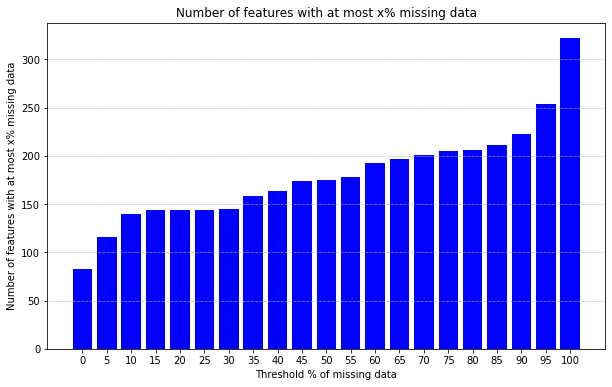

Final shape: (328135, 78)
Remaining features: 78
kept features: ['_STATE', 'GENHLTH', 'PHYSHLTH', 'MENTHLTH', 'HLTHPLN1', 'PERSDOC2', 'MEDCOST', 'CHECKUP1', 'BPHIGH4', 'BLOODCHO', 'CHOLCHK', 'TOLDHI2', 'CVDSTRK3', 'ASTHMA3', 'CHCSCNCR', 'CHCOCNCR', 'CHCCOPD1', 'HAVARTH3', 'ADDEPEV2', 'CHCKIDNY', 'DIABETE3', 'SEX', 'MARITAL', 'EDUCA', 'RENTHOM1', 'VETERAN3', 'EMPLOY1', 'CHILDREN', 'INCOME2', 'INTERNET', 'WEIGHT2', 'HEIGHT3', 'QLACTLM2', 'USEEQUIP', 'BLIND', 'DECIDE', 'DIFFWALK', 'DIFFDRES', 'DIFFALON', 'SMOKE100', 'USENOW3', 'ALCDAY5', 'FRUITJU1', 'FRUIT1', 'FVBEANS', 'FVGREEN', 'FVORANG', 'VEGETAB1', 'EXERANY2', 'EXRACT11', 'EXEROFT1', 'EXERHMM1', 'EXRACT21', 'STRENGTH', 'SEATBELT', 'FLUSHOT6', 'PNEUVAC3', 'HIVTST6', 'QSTLANG', '_CHISPNC', '_PRACE1', '_MRACE1', '_HISPANC', '_RACE', '_RACEGR3', '_RACE_G1', '_AGEG5YR', '_AGE65YR', '_AGE80', '_AGE_G', 'DROCDY3_', 'MAXVO2_', 'FC60_', 'PADUR1_', 'PAFREQ1_', '_LMTACT1', '_LMTWRK1', '_LMTSCL1']


In [6]:
CSV_PATH = "data/dataset/x_train.csv"

# 1) read headers
with open(CSV_PATH, 'r') as file:
    reader = csv.reader(file)
    feature_names = next(reader)

# 2) load numeric data (skip header row)
X = np.genfromtxt(
    CSV_PATH,
    delimiter=",",
    skip_header=1,
    dtype=float,
    missing_values=("","7","77","777","9","99","999"), #Standard global missing code in the provided dataset
    filling_values=np.nan
)
print(X)

# 3) compute % missing
missing_pct = np.isnan(X).mean(axis=0) * 100
thresholds = np.arange(0, 101, 5)
feature_counts = [(missing_pct <= threshold).sum() for threshold in thresholds]

plt.figure(figsize=(10, 6))
plt.bar(thresholds, feature_counts, color='b', width=4)
plt.xlabel('Threshold % of missing data')
plt.ylabel('Number of features with at most x% missing data')
plt.title('Number of features with at most x% missing data')
plt.xticks(thresholds)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("plot.png", dpi=300)
plt.show()

# 4) keep features with ≤40% missing
mask40 = missing_pct <= 40
X = X[:, mask40]
feature_names = [name for i, name in enumerate(feature_names) if mask40[i]]

# 5) remove specific administrative/date/ID columns
admin_cols = ['Id', 'FMONTH', 'IDATE', 'IMONTH', 'IDAY', 'IYEAR',
               'DISPCODE', 'SEQNO', '_PSU', 'QSTVER', 'MSCODE', '_STSTR']

# 6) Columns that are calculated/derived from other columns in the list are removed. 
calculated_cols = [
    "_RFHLTH", "_HCVU651", "_RFHYPE5", "_CHOLCHK", "_RFCHOL",
    "_LTASTH1", "_CASTHM1", "_ASTHMS1", "_DRDXAR1",
    "HTIN4", "HTM4", "WTKG3", "_BMI5", "_BMI5CAT", "_RFBMI5",
    "_CHLDCNT", "_EDUCAG", "_INCOMG",
    "_SMOKER3", "_RFSMOK3","DRNKANY5",
    "_DRNKWEK", "_RFBING5", "_RFDRHV5",
    "FTJUDA1_", "FRUTDA1_", "BEANDAY_", "GRENDAY_", "ORNGDAY_", "VEGEDA1_",
    "_MISFRTN", "_MISVEGN", "_FRTRESP", "_VEGRESP",
    "_FRUTSUM", "_VEGESUM", "_FRTLT1", "_VEGLT1", "_FRT16", "_VEG23", "_FRUITEX", "_VEGETEX",
    "METVL11_", "ACTIN11_", "_MINAC11",
    "METVL21_", "ACTIN21_", "_MINAC21",
    "STRFREQ_", "PAMISS1_", "PAMIN11_", "PAMIN21_",
    "PA1MIN_", "PAVIG11_", "PAVIG21_", "PA1VIGM_",
    "_PACAT1", "_PAINDX1", "_PA150R2", "_PA300R2", "_PA30021",
    "_PASTRNG", "_PAREC1", "_PASTAE1",
    "_TOTINDA",
    "_RFSEAT2", "_RFSEAT3", "_AIDTST3","_RACEG21"
]

# 7) Removing "weights assigned to each respondent" - hidden data in the dataset
weights = ["_STRWT","_RAWRAKE","_WT2RAKE","_DUALUSE","_DUALCOR","_LLCPWT"]

remove_cols = admin_cols+calculated_cols+weights

remove_idx = [i for i, name in enumerate(feature_names) if name in remove_cols]
X_reduced = np.delete(X, remove_idx, axis=1)
feature_names_reduced = [name for i, name in enumerate(feature_names) if i not in remove_idx]

# 8) check results
print("Final shape:", X_reduced.shape)
print("Remaining features:", len(feature_names_reduced))
print("kept features:", feature_names_reduced)


In [8]:
# ---------- Default superset: covers DK/Refused across BRFSS ----------
DEFAULT_MISS = np.array([7, 9, 77, 99, 777, 999], dtype=float)

# Columns that need a DIFFERENT code set (override the default)
SPECIAL_MISS = {
    # only 9 means missing
    "_PRACE1": [9], "_MRACE1": [9], "_HISPANC": [9], "_RACE": [9],
    "_RACEGR3": [9], "_RACE_G1": [9], "EMPLOY1": [9], "USENOW3": [9],
    "MARITAL": [9], "EDUCA": [9], "QSTLANG": [9], "_AGE65YR": [9],
    "_AGE80": [9], "_AGE_G": [9],

    # activity type uses 77/99 only
    "EXRACT11": [77, 99], "EXRACT21": [77, 99],

    # children/income use 77/99
    "CHILDREN": [77, 99], "INCOME2": [77, 99],

    # special case: age bins (keep 1..13)
    "_AGEG5YR": [14],
    
    # weight/height uses 7777,9999
    "WEIGHT2" : [7777,9999], "HEIGHT3": [7777,9999],"MAXVO2_": [7777, 9999],
    "FC60_":   [7777, 9999],
    
    # has its own list 
    "_STATE" : [7,77,99, 777, 999]
    
}

SPECIAL_TO_ZERO = {"PHYSHLTH": 88, "MENTHLTH": 88, "CHILDREN": 88}  # add others ONLY if codebook says 88 = None there

def apply_semantics(col, name):
    # map special "None" codes to a real value first (e.g., 0 days)
    code = SPECIAL_TO_ZERO.get(name)
    if code is not None:
        col = col.astype(float, copy=True)
        col[col == float(code)] = 0.0
    return col

def apply_missing_codes(col, name):
    """
    Replace coded missings with NaN. Uses a big default set,
    overridden by SPECIAL_MISS where needed.
    """
    col = col.astype(float, copy=True)
    codes = np.array(SPECIAL_MISS.get(name, DEFAULT_MISS), dtype=float)
    if codes.size:
        col[np.isin(col, codes)] = np.nan
    return col

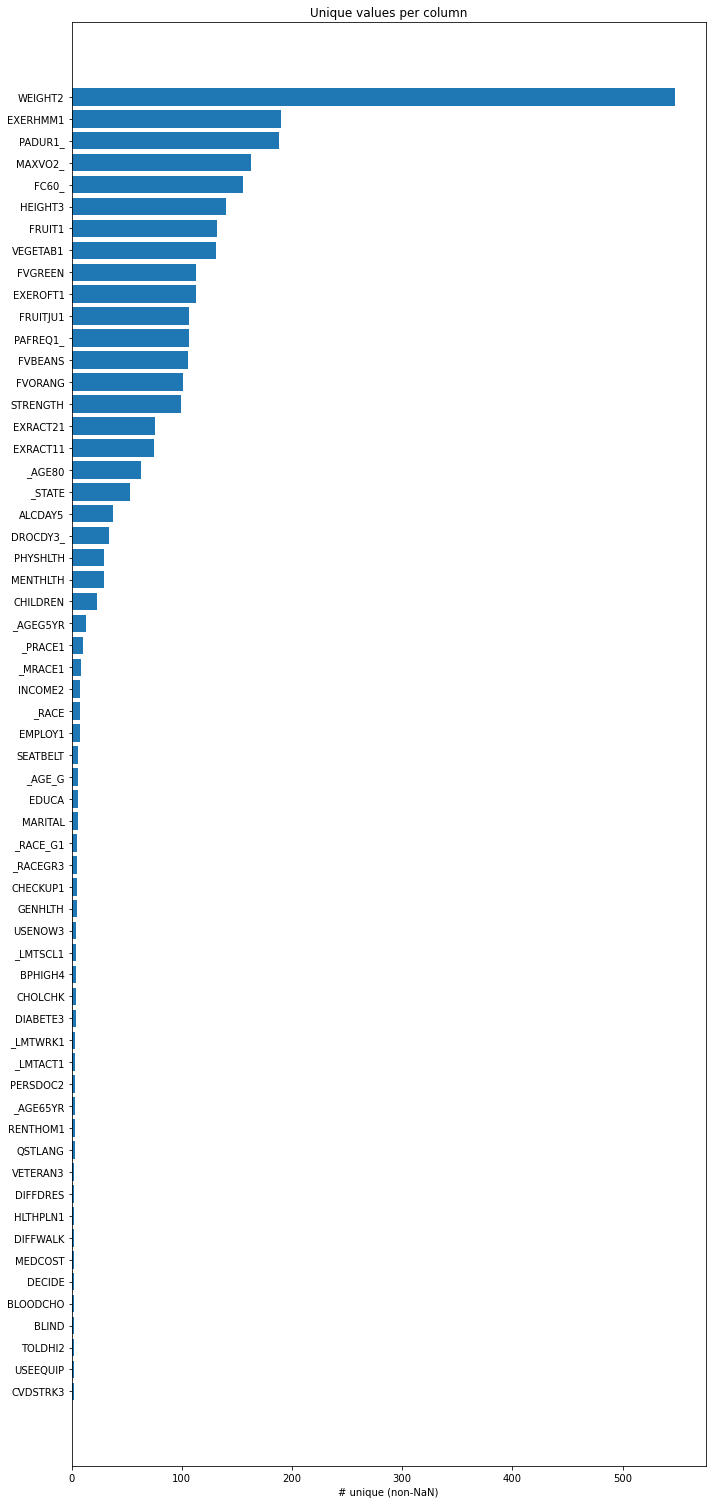

Column | #unique | %unique_of_nonmissing
WEIGHT2                   548      0.18%
EXERHMM1                  190      0.09%
PADUR1_                   188      0.09%
MAXVO2_                   163      0.05%
FC60_                     156      0.05%
HEIGHT3                   140      0.04%
FRUIT1                    132      0.04%
VEGETAB1                  131      0.04%
FVGREEN                   113      0.04%
EXEROFT1                  113      0.05%
FRUITJU1                  107      0.04%
PAFREQ1_                  107      0.06%
FVBEANS                   106      0.04%
FVORANG                   101      0.03%
STRENGTH                   99      0.03%
EXRACT21                   76      0.04%
EXRACT11                   75      0.03%
_AGE80                     63      0.02%
_STATE                     53      0.02%
ALCDAY5                    38      0.01%
DROCDY3_                   34      0.01%
PHYSHLTH                   29      0.01%
MENTHLTH                   29      0.01%
CHILDREN        

In [9]:
# Determine if categorical (impute with mode) or numerical (impute with median)
def plot_unique_counts(
    X, feature_names,
    top_n=None,               # e.g., 50 to show top 50 by uniqueness; None = all
    sort_desc=True,           # sort by unique count
    filename="unique_counts.png"
):
    X = np.asarray(X, dtype=float)
    n, p = X.shape

    uniq_counts = []
    prop_unique = []
    for j in range(p):
        col = X[:, j]
        v = col[~np.isnan(col)]
        k = np.unique(v).size
        uniq_counts.append(k)
        prop_unique.append(k / max(len(v), 1))

    uniq_counts = np.array(uniq_counts)
    prop_unique = np.array(prop_unique)

    idx = np.arange(p)
    if sort_desc:
        idx = np.argsort(-uniq_counts)
    if top_n is not None:
        idx = idx[:top_n]

    labels = [feature_names[i] for i in idx]
    vals   = uniq_counts[idx]

    # --- bar plot (horizontal for readability) ---
    plt.figure(figsize=(10, max(6, 0.35*len(idx))))
    plt.barh(np.arange(len(idx)), vals)
    plt.yticks(np.arange(len(idx)), labels)
    plt.gca().invert_yaxis()
    plt.xlabel("# unique (non-NaN)")
    plt.title("Unique values per column")
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()
    
    # --- quick console table ---
    print("Column | #unique | %unique_of_nonmissing")
    for i in idx:
        print(f"{feature_names[i]:<20s} {uniq_counts[i]:>8d} {prop_unique[i]*100:>9.2f}%")

    return uniq_counts, prop_unique

for j, name in enumerate(feature_names_reduced):
    col = X_reduced[:, j]
    col = apply_missing_codes(col, name)
    col = apply_semantics(col, name)
    X_reduced[:, j] = col

uniq_counts, prop_unique = plot_unique_counts(
    X_reduced, feature_names_reduced,
    top_n=60,            # show top 60 most unique; set None to show all
    sort_desc=True,
    filename="unique_counts.png"
)

As can be seen from the plot above, the categorical feature with highest number of unique values is EXTRACT21 at 76 unique values. However there are numeric values e.g. PHYSHLTH with fewer unique values. Hence we need to define some other metrics. For example, the % of unique values, but additionally if several values appear only once (implying that the field is most likely numeric) and the 

In [11]:
def simple_impute_plan(
    X, feature_names,
    abs_unique_cap=76,          # if #unique < abs_unique_cap  -> categorical (mode)
    rel_unique_cap=0.04,        # if %unique < rel_unique_cap  -> categorical (mode)
    singleton_ratio_thresh=0.60,# if ≥ threshold occur once    -> numeric (median)
    force_mode=None,            # e.g., {"_STATE","EXRACT11","EXRACT21"}
    force_median=None
):
    X = np.asarray(X, dtype=float)
    plan = {}
    force_mode  = set(force_mode or [])
    force_median= set(force_median or [])

    for j, name in enumerate(feature_names):
        # name-based overrides
        if name in force_mode:
            plan[name] = "mode";   continue
        if name in force_median:
            plan[name] = "median"; continue
            
        v = X[:, j][~np.isnan(X[:, j])]
        if v.size == 0:
            plan[name] = "mode";   continue
            
        uniq, cnt = np.unique(v, return_counts=True) 
        k = uniq.size 
        prop_unique = k / v.size 
        singleton_ratio = (cnt == 1).sum() / k 
        
        if k < 20: 
            plan[name] = "mode"
        elif k < abs_unique_cap and prop_unique > rel_unique_cap and singleton_ratio <= singleton_ratio_thresh: 
            plan[name] = "mode"
        else: 
            plan[name] = "median"

    return plan

def split_mode_median(plan, feature_names):
    mode_cols   = [n for n in feature_names if plan.get(n) == "mode"]
    median_cols = [n for n in feature_names if plan.get(n) == "median"]
    return mode_cols, median_cols


plan = simple_impute_plan(X_reduced, feature_names_reduced,
                          abs_unique_cap=76,
                          rel_unique_cap=0.04,
                          singleton_ratio_thresh=0.40,
                          force_mode = {"_STATE","EXRACT11","EXRACT21"})

mode_cols, median_cols = split_mode_median(plan, feature_names_reduced)
print("Mode (categorical):", len(mode_cols), mode_cols)
print("Median (numeric):",   len(median_cols), median_cols)

Mode (categorical): 57 ['_STATE', 'GENHLTH', 'HLTHPLN1', 'PERSDOC2', 'MEDCOST', 'CHECKUP1', 'BPHIGH4', 'BLOODCHO', 'CHOLCHK', 'TOLDHI2', 'CVDSTRK3', 'ASTHMA3', 'CHCSCNCR', 'CHCOCNCR', 'CHCCOPD1', 'HAVARTH3', 'ADDEPEV2', 'CHCKIDNY', 'DIABETE3', 'SEX', 'MARITAL', 'EDUCA', 'RENTHOM1', 'VETERAN3', 'EMPLOY1', 'INCOME2', 'INTERNET', 'QLACTLM2', 'USEEQUIP', 'BLIND', 'DECIDE', 'DIFFWALK', 'DIFFDRES', 'DIFFALON', 'SMOKE100', 'USENOW3', 'EXERANY2', 'EXRACT11', 'EXRACT21', 'SEATBELT', 'FLUSHOT6', 'PNEUVAC3', 'HIVTST6', 'QSTLANG', '_CHISPNC', '_PRACE1', '_MRACE1', '_HISPANC', '_RACE', '_RACEGR3', '_RACE_G1', '_AGEG5YR', '_AGE65YR', '_AGE_G', '_LMTACT1', '_LMTWRK1', '_LMTSCL1']
Median (numeric): 21 ['PHYSHLTH', 'MENTHLTH', 'CHILDREN', 'WEIGHT2', 'HEIGHT3', 'ALCDAY5', 'FRUITJU1', 'FRUIT1', 'FVBEANS', 'FVGREEN', 'FVORANG', 'VEGETAB1', 'EXEROFT1', 'EXERHMM1', 'STRENGTH', '_AGE80', 'DROCDY3_', 'MAXVO2_', 'FC60_', 'PADUR1_', 'PAFREQ1_']


In [12]:
save_path = "data/dataset/impute_vals"
# Imputation helpers
def impute_mean(arr):
    mask = np.isnan(arr)
    if np.all(mask):  # nothing to learn
        return arr
    arr[mask] = np.nanmean(arr)
    return arr

def impute_median(arr):
    v = arr[~np.isnan(arr)]
    if v.size == 0: return np.nan
    return np.nanmedian(v)

def impute_mode(arr):
    v = arr[~np.isnan(arr)]
    if v.size == 0: return np.nan
    u, c = np.unique(v, return_counts=True)
    return u[np.argmax(c)]

def clean_then_impute(X, feature_names, mode_list, median_list,save_path):
    """
    X: np.ndarray (n_samples, n_features) — numeric (float ok)
    feature_names: list of column names in the same order as X
    Returns cleaned+imputed copy of X (float).
    """
    X = np.array(X, dtype=float, copy=True)
    p = X.shape[1]
    fillers = np.full(p, np.nan, dtype=float)

    for j, name in enumerate(feature_names):
        col = X[:, j]

        if name in mode_list:
            fill = impute_mode(col)
        elif name in median_list:
            fill = impute_median(col)
        fillers[j] = fill

        # impute TRAIN with learned filler
        if not np.isnan(fill):
            m = np.isnan(col)
            if np.any(m):
                col[m] = fill
        X[:, j] = col

    # save to npz
    np.savez(save_path, fillers=fillers.astype(float),
             feature_names=np.array(feature_names, dtype=object))

    return X, fillers

X_clean, fillers = clean_then_impute(X_reduced, feature_names_reduced,mode_cols, median_cols,save_path)
print(X_clean)
print(X_clean.shape)

[[53.  2.  1. ...  3.  3.  4.]
 [33.  4.  0. ...  3.  3.  4.]
 [20.  2.  0. ...  2.  2.  3.]
 ...
 [39.  3.  0. ...  3.  3.  4.]
 [33.  3.  0. ...  3.  3.  4.]
 [32.  2.  0. ...  2.  2.  3.]]
(328135, 78)


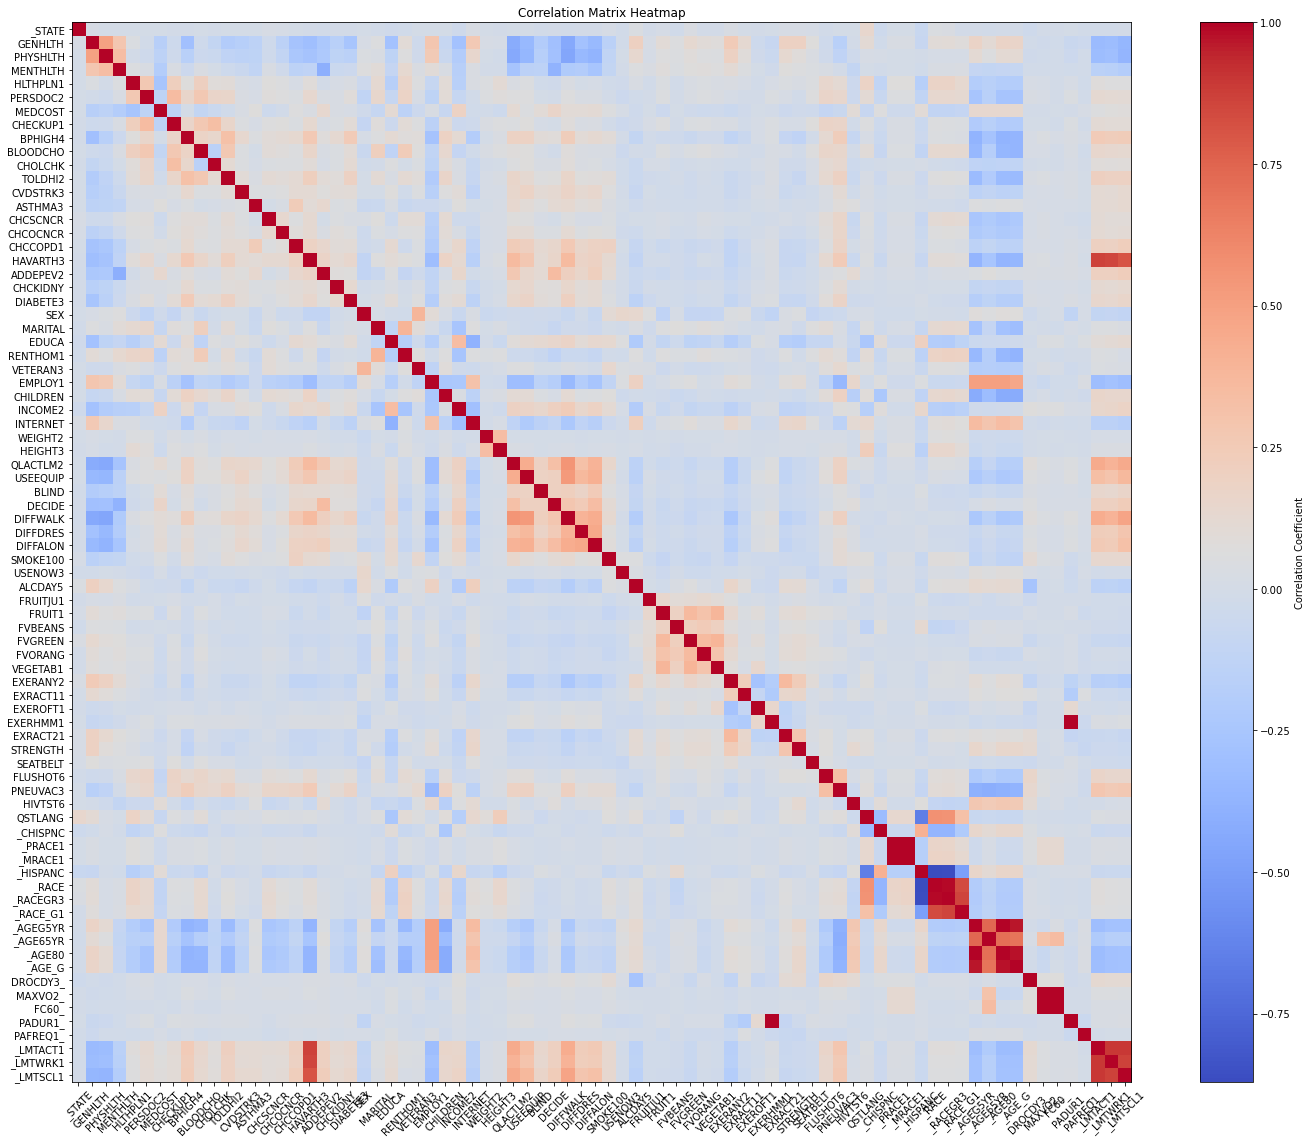

HAVARTH3 ~ _LMTACT1  r=0.999
HAVARTH3 ~ _LMTWRK1  r=0.998
HAVARTH3 ~ _LMTSCL1  r=0.994
EXERHMM1 ~ PADUR1_  r=0.993
_PRACE1 ~ _MRACE1  r=0.989
_HISPANC ~ _RACE  r=0.971
_HISPANC ~ _RACEGR3  r=0.968
_RACE ~ _RACEGR3  r=0.895
_RACE ~ _RACE_G1  r=0.891
_RACEGR3 ~ _RACE_G1  r=-0.871
_AGEG5YR ~ _AGE80  r=0.868
_AGEG5YR ~ _AGE_G  r=0.868
_AGE80 ~ _AGE_G  r=-0.861
MAXVO2_ ~ FC60_  r=0.859
_LMTACT1 ~ _LMTWRK1  r=0.850
_LMTACT1 ~ _LMTSCL1  r=0.836
_LMTWRK1 ~ _LMTSCL1  r=0.809


In [13]:
# Correlation and heatmap

# 1) Correlation (Pearson), safe for constant columns
corr_matrix = np.corrcoef(X_clean, rowvar=False)

# 2) Simple heatmap (matplotlib only)
plt.figure(figsize=(20, 16))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Correlation Coefficient')

labels = feature_names_reduced
plt.xticks(ticks=np.arange(len(labels)), labels=labels, rotation=45)
plt.yticks(ticks=np.arange(len(labels)), labels=labels)
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()

# Listing highly correlated features
def high_corr_pairs(C, feature_names, threshold=0.90):
    C = np.asarray(C, float)
    p = C.shape[0]
    iu = np.triu_indices(p, k=1)          # upper triangle
    r = C[iu]
    mask = np.abs(r) >= threshold
    I, J, R = iu[0][mask], iu[1][mask], r[mask]

    # sorted by absolute correlation (strongest first)
    order = np.argsort(-np.abs(R))
    return [(feature_names[I[k]], feature_names[J[k]], float(R[order[k]])) for k in range(len(order))]

pairs = high_corr_pairs(corr_matrix, feature_names_reduced, threshold=0.80)
for a,b,r in pairs:
    print(f"{a} ~ {b}  r={r:.3f}")

Based on the heatmap and list generated above, we can remove highly correlated columns with r>0.9, such as "_LMTACT1","_LMTWRK1","_LMTSCL1","PADUR1_","_MRACE1","_HISPANC".

In [14]:
corr_features = ["_LMTACT1","_LMTWRK1","_LMTSCL1","DRNKANY5","PADUR1_","_MRACE1","_HISPANC"]

# 1) map names to indices
name_to_idx = {n: i for i, n in enumerate(feature_names_reduced)}

# 2) build sorted index list to drop (ignore any missing names)
drop_idx = sorted({name_to_idx[n] for n in corr_features if n in name_to_idx})

# 3) drop from X and from feature_names (keep alignment)
X_final = np.delete(X_clean, drop_idx, axis=1)
feature_names_final = [n for i, n in enumerate(feature_names_reduced) if i not in set(drop_idx)]

In [18]:
# Standardisation

def fit_standardizer(matrix):
    """
    Fit per-feature mean and std. Safe for constant columns.
    Returns a dict with 'mean' and 'std'.
    """
    matrix = np.asarray(matrix, dtype=float)
    mean = matrix.mean(axis=0)
    std  = matrix.std(axis=0, ddof=1)
    std_safe = np.where(std == 0.0, 1.0, std)  # avoid divide-by-zero
    return {"mean": mean, "std": std_safe}

def transform_standardizer(matrix, scaler):
    """
    Apply z-score scaling using a fitted scaler.
    """
    matrix = np.asarray(matrix, dtype=float)
    return (matrix - scaler["mean"]) / scaler["std"]

def save_standardizer(scaler, savepath):
    np.savez(savepath, mean=scaler["mean"], std=scaler["std"])

def load_standardizer(path="scaler_zscore.npz"):
    d = np.load(path, allow_pickle=True)
    return {"mean": d["mean"], "std": d["std"]}

In [19]:
save_path = "data/dataset/scaler_zscore"

std = fit_standardizer(X_final)
save_standardizer(std, save_path)
X_std = transform_standardizer(X_final, std)

print(X_std)

[[ 1.43629421 -0.51478561 -0.34876028 ... -0.1233834  -0.11255807
  -0.60546915]
 [ 0.18877189  1.33519744 -0.46339974 ... -0.10698043 -0.10978875
  -0.10426043]
 [-0.62211762 -0.51478561 -0.46339974 ... -0.15128732 -0.11717361
  -0.10426043]
 ...
 [ 0.56302859  0.41020591 -0.46339974 ... -0.16175128 -0.11892751
   0.39694829]
 [ 0.18877189  0.41020591 -0.46339974 ... -0.03439254 -0.09760373
  -1.37382211]
 [ 0.12639577 -0.51478561 -0.46339974 ... -0.10245547 -0.10905026
   0.39694829]]


In [1]:
def pca_transform(standardized_data, model_path="pca_model.npz"):
    """
    Apply a previously-fitted PCA to new standardized data (e.g., validation/test).
    """
    X = np.asarray(standardized_data, dtype=float)
    d = np.load(model_path, allow_pickle=True)
    components = d["components"]             # (p x k)
    # sanity: feature count must match
    n_features = int(d["n_features"][0])
    assert X.shape[1] == n_features, f"Expected {n_features} features, got {X.shape[1]}"
    return X @ components


In [21]:
import numpy as np

def pca_fit_and_save_train(X_train_std, variance_threshold, model_path, csv_path, row_ids=None, row_id_name="row_id"):
    """
    X_train_std: (n x p) TRAIN matrix (already standardized; no NaNs)
    variance_threshold: e.g. 0.95 (keep PCs explaining >=95% variance)
    model_path: where to save PCA model (.npz)
    csv_path:   where to save projected PCs (.csv)
    row_ids:    optional iterable of length n to prepend as first column
    """
    X = np.asarray(X_train_std, dtype=float)

    # Covariance (symmetric) -> eig
    C = np.cov(X, rowvar=False, ddof=1)
    evals, evecs = np.linalg.eigh(C)          # ascending eigenvalues
    order = np.argsort(evals)[::-1]           # sort descending
    evals = evals[order]
    evecs = evecs[:, order]                   # columns = eigenvectors

    # Choose k by variance threshold
    evr = evals / evals.sum()
    k = int(np.searchsorted(np.cumsum(evr), variance_threshold) + 1)

    # Components and projection
    components = evecs[:, :k]                 # (p x k)
    Z = X @ components                        # (n x k)

    # Save PCA model
    np.savez(
        model_path,
        components=components,
        explained_variance=evals[:k],
        explained_variance_ratio=evr[:k],
        variance_threshold=np.array([variance_threshold]),
        n_features=np.array([X.shape[1]], dtype=int)
    )

    # Save TRAIN projection to CSV
    if row_ids is not None:
        row_ids = np.asarray(row_ids).reshape(-1, 1)
        out = np.concatenate([row_ids, Z], axis=1)
        header = ",".join([row_id_name] + [f"PC{i+1}" for i in range(Z.shape[1])])
    else:
        out = Z
        header = ",".join([f"PC{i+1}" for i in range(Z.shape[1])])

    np.savetxt(csv_path, out, delimiter=",", fmt="%.6f", header=header, comments="")
    return Z  # in case you want it in-memory too


# Assuming X_train_std is your standardized full training matrix
Z_train = pca_fit_and_save_train(
    X_std,
    variance_threshold=0.95,
    model_path="data/dataset/pca_train_model.npz",
    csv_path="data/dataset/pca_train_projection.csv", 
    row_id_name="idx"
)


### We have decided to keep features with missing data up to 40% after plot analysis and some article readings.

#### 1. Demographics (baseline predictors)
- `SEX`
- `AGEG5YR`, `_AGE65YR` (senior flag), `_AGE80` (80+)
- `INCOME2`, `_INCOMG`
- `MARITAL`
- `EMPLOY1`
- `RENTHOM1`
- `CHILDREN`, `_CHLDCNT`
- `_RACE`, `_PRACE1`, `_HISPANC` (broad + detailed race/ethnicity)

#### 2. General health & healthcare access
- `GENHLTH`
- `PHYSHLTH`
- `MENTHLTH`
- `HLTHPLN1` (health coverage)
- `PERSDOC2` (personal doctor)
- `MEDCOST` (cost barrier)
- `CHECKUP1` (routine checkup)

#### 3. Chronic conditions
- `BPHIGH4` (high blood pressure)
- `BLOODCHO`, `CHOLCHK`, `TOLDHI2` (cholesterol)
- `CVDSTRK3` (stroke)
- `ASTHMA3`
- `CHCSCNCR`, `CHCOCNCR` (cancers)
- `CHCCOPD1` (COPD)
- `HAVARTH3` (arthritis)
- `ADDEPEV2` (depression)
- `CHCKIDNY` (kidney disease)
- `DIABETE3` (diabetes)

#### 4. Behaviors – smoking, alcohol, diet, exercise, prevention
- **Smoking:** `SMOKE100`, `USENOW3`, `_SMOKER3`, `_RFSMOK3`
- **Alcohol:** `ALCDAY5`, `DRNKANY5`, `_RFBING5`, `_RFDRHV5`
- **Diet:** `FRUIT1`, `FVGREEN`, `FVORANG`, `VEGETAB1`, `FRUITJU1`, `FVBEANS`, `_FRUTSUM`, `_VEGESUM`, `_FRTLT1`, `_VEGLT1`
- **Physical activity:** `EXERANY2`, `_TOTINDA`, `STRENGTH`, `_PA150R2`, `_PA300R2`, `_PASTRNG`
- **Safety & prevention:** `SEATBELT`, `FLUSHOT6`, `PNEUVAC3`, `HIVTST6`

#### 5. Anthropometrics
- `WEIGHT2`, `HEIGHT3`, `WTKG3`
- `_BMI5`, `_BMI5CAT`, `_RFBMI5`

#### 6. Psychosocial / functional health
- `QLACTLM2` (activity limitation)
- `USEEQUIP` (equipment use for disability)
- `BLIND`
- `DECIDE` (cognitive difficulties)
- `DIFFWALK`, `DIFFDRES`, `DIFFALON`


<h3>Now we perform first data preprocessing</h3>

In [ ]:
'''
x = [i in kept_features for i in headers] #headers filtering
print(len(x))
new_headers = [] # to maintain the order
for i in headers:
    if i in kept_features:
        new_headers.append(i) #makes a list of only the kept features, preserve the original order

mapping = {new_headers[i]:i for i in range(len(new_headers))} # Builds a dictionary linking each feature name to its column index in the reduced dataset, for preprocessing
print(mapping)
'''

DATA CLEANING : 
- separate numerical features from categorical features
- univariate outliers detection fro rough cleaning 
- multivariate outliers detection for final cleaning


In [ ]:
'''#checking which variables, if any, are numerical
numerical_headers= []
for i in new_headers :
    if len(np.unique(x_train_filtered[:, mapping[i]], )) > 20: #considering them continuous numerical features if they can have more than 20 different values
        numerical_headers.append(i)   

print(len(numerical_headers))
print(numerical_headers)
'''

For each numerical variable we check if there are some elements in the sample that are too distant from the others

In [ ]:
'''#visualization --- > plots saved in features plots, don't run again
num_numerical = len(numerical_headers)

for i, header in enumerate(numerical_headers):
    plt.figure(figsize=(10, 6)) 
    plt.scatter(
        np.arange(x_train_filtered.shape[0]),
        x_train_filtered[:, mapping[header]],
        color="blue",
        marker="o",
        label=header
    )
    plt.title(header)
    plt.legend()
    plt.tight_layout()
    
    
    plt.savefig(f"{header}.png")  
    
    
    #plt.show()

'''

In [ ]:
'''#replacing nans with the median value of the same feature 

for i in new_headers : 
    col = x_train_filtered[:, mapping[i]]
    median = np.nanmedian(col)
    mask_nan = np.isnan(col)
    col[mask_nan] = median
    x_train_filtered[:, mapping[i]] = col
'''

we apply IQR algorithm for univariate outliers detection for a rough cleaning of data

In [ ]:
'''
#import sys, importlib
#sys.path.insert(0, r'C:\\Users\\sanni\\OneDrive\\Desktop\\POLIMI\\EPFL\\ML\\Project_1\\project-1-girl_power')

import outliers
#importlib.reload(outliers)  

outliers_indexes = []



for i in numerical_headers : 
    outliers_indexes.append(outliers.iqr(x_train_filtered[:, mapping[i]], 0.01, 0.99))

outliers_indexes = np.unique([idx for sublist in outliers_indexes for idx in sublist]) #removing doubles

print(outliers_indexes)
print(outliers_indexes.shape)
print(x_train.shape[0])
'''

We then apply the FAST-MCD algorithm for multivariate outliers analysis

In [ ]:
'''
import sys, importlib
sys.path.insert(0, r'C:\\Users\\sanni\\OneDrive\\Desktop\\POLIMI\\EPFL\\ML\\Project_1\\project-1-girl_power')

import outliers
importlib.reload(outliers)  


indices = [mapping[h] for h in numerical_headers]
X_num = x_train_filtered[:, indices]


h_val = int(0.75 * len(y_train))

best_mu, best_Sigma, best_d = outliers.fast_mcd(X_num, h_val, 10, 1000, 1e-6, 1)

print(best_mu)
print(best_Sigma)
print(best_d)
'''